# Vehicle Crimes Corridor Analysis (POLICY-02)

**Objective:** Map vehicle-related crimes and quantify their proximity to major transit/highway corridors.

## Overview

This notebook analyzes the spatial relationship between vehicle crimes (Theft from Vehicle, Motor Vehicle Theft) and major transportation corridors in Philadelphia:

1. **Load and filter** vehicle crimes from enriched dataset
2. **Create 500m buffers** around corridor geometries (highways + SEPTA lines)
3. **Calculate percentage** of vehicle crimes within corridor buffers
4. **Visualize** with static and interactive maps
5. **Break down** by corridor type (highway vs subway)

**Outputs:**
- `reports/vehicle_crimes_corridor_map.png` - Static map with corridor overlay
- `reports/vehicle_corridor_analysis.md` - Summary with % quantification
- `reports/vehicle_crimes_corridor_stats.csv` - Corridor statistics

In [1]:
# Parameters (can be injected by papermill)
VERSION = "v1.0"
FAST_MODE = False

In [2]:
import time
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if (cwd / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd  # Running from project root (papermill)
elif (cwd.parent / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd.parent  # Running from notebooks/ dir
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")

print(f"DEBUG repo_root: {repo_root}")
sys.path.insert(0, str(repo_root))

REPORTS_DIR = (repo_root / 'reports').resolve()
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reports dir: {REPORTS_DIR}")

artifacts = []
RUNTIME_START = time.time()

DEBUG repo_root: /Users/dustinober/Projects/Crime Incidents Philadelphia
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [3]:
import platform
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from shapely.geometry import Point
from shapely.ops import unary_union

print("Reproducibility Info")
print("=" * 40)
print(f"Timestamp (local): {datetime.now().isoformat()}")
print(f"Python: {platform.python_version()}")
print(f"Platform: {platform.platform()}")
print(f"pandas: {pd.__version__}")
print(f"geopandas: {gpd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

Reproducibility Info
Timestamp (local): 2026-02-02T20:24:12.644451
Python: 3.13.9
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
pandas: 2.3.3
geopandas: 1.1.2
matplotlib: 3.10.6


## 1. Load Configuration and Data

In [4]:
from analysis.utils import load_data
from analysis.phase3_config_loader import Phase3Config

# Load Phase 3 configuration
config = Phase3Config()
print(f"Config version: {config.version}")
print(f"Vehicle crime codes: {config.vehicle_crimes['text_codes']}")
print(f"Buffer distance: {config.vehicle_crimes['buffer_meters']}m")

Config version: 1.0
Vehicle crime codes: ['Theft from Vehicle', 'Motor Vehicle Theft']
Buffer distance: 500m


In [5]:
# Load crime data
df = load_data(clean=True)
print(f"Total crime records loaded: {len(df):,}")

# Filter to vehicle crimes
vehicle_codes = config.vehicle_crimes['text_codes']
df_vehicle = df[df['text_general_code'].isin(vehicle_codes)].copy()

print(f"\nVehicle crime incidents: {len(df_vehicle):,}")
print(f"Crime type breakdown:")
print(df_vehicle['text_general_code'].value_counts())

Total crime records loaded: 3,496,353

Vehicle crime incidents: 409,453
Crime type breakdown:
text_general_code
Theft from Vehicle                         283814
Motor Vehicle Theft                        125639
Aggravated Assault No Firearm                   0
Vandalism/Criminal Mischief                     0
Vagrancy/Loitering                              0
Thefts                                          0
Robbery No Firearm                              0
Robbery Firearm                                 0
Receiving Stolen Property                       0
Rape                                            0
Public Drunkenness                              0
Prostitution and Commercialized Vice            0
Other Sex Offenses (Not Commercialized)         0
Other Assaults                                  0
Offenses Against Family and Children            0
Narcotic / Drug Law Violations                  0
Aggravated Assault Firearm                      0
Liquor Law Violations                 

In [6]:
# Clean coordinates - filter to valid Philadelphia bounds
bounds = config.coordinate_bounds

mask = (
    df_vehicle['point_x'].notna() &
    df_vehicle['point_y'].notna() &
    (df_vehicle['point_x'] >= bounds['min_lon']) &
    (df_vehicle['point_x'] <= bounds['max_lon']) &
    (df_vehicle['point_y'] >= bounds['min_lat']) &
    (df_vehicle['point_y'] <= bounds['max_lat'])
)

df_vehicle = df_vehicle[mask].copy()
print(f"Vehicle crimes with valid coordinates: {len(df_vehicle):,}")

Vehicle crimes with valid coordinates: 400,723


In [7]:
# Load corridor geometries
corridors_path = repo_root / 'data' / 'boundaries' / 'corridors.geojson'
corridors = gpd.read_file(corridors_path)

print(f"Loaded {len(corridors)} corridor segments")
print(f"\nCorridor types:")
print(corridors['type'].value_counts())

print(f"\nUnique corridor names:")
for name in sorted(corridors['name'].unique()):
    count = len(corridors[corridors['name'] == name])
    print(f"  {name}: {count} segments")

Loaded 1624 corridor segments

Corridor types:
type
highway    1622
subway        2
Name: count, dtype: int64

Unique corridor names:
  Broad Street Line: 1 segments
  I 295;US 130: 11 segments
  I 676: 92 segments
  I 676;US 30: 61 segments
  I 676;US 30 Eastbound: 1 segments
  I 76: 238 segments
  I 76;US 1: 3 segments
  I 76;US 30: 7 segments
  I 95: 283 segments
  Market-Frankford Line: 1 segments
  US 1: 425 segments
  US 13: 17 segments
  US 130: 214 segments
  US 130;CR 551: 6 segments
  US 130;CR 551 Spur: 10 segments
  US 130;CR 551;Route 47: 1 segments
  US 13;US 30: 3 segments
  US 1;PA 63: 26 segments
  US 1;US 13: 156 segments
  US 30;US 1 Alternate Truck: 33 segments
  US 30;US 130: 35 segments


## 2. Create Corridor Buffers

In [8]:
# Buffer distance from config
buffer_meters = config.vehicle_crimes['buffer_meters']

# Project to UTM (meters) for accurate buffering
# UTM Zone 18N (EPSG:32618) is appropriate for Philadelphia
corridors_utm = corridors.to_crs(epsg=32618)

# Create buffered corridors
corridors_buffered = corridors_utm.copy()
corridors_buffered['geometry'] = corridors_utm.geometry.buffer(buffer_meters)

# Convert back to WGS84 for spatial operations with crime points
corridors_buffered = corridors_buffered.to_crs(epsg=4326)

print(f"Created {buffer_meters}m buffers around {len(corridors)} corridor segments")

Created 500m buffers around 1624 corridor segments


In [9]:
# Create combined corridor buffers by type
# Union all highway segments
highway_mask = corridors_buffered['type'] == 'highway'
highway_buffer = unary_union(corridors_buffered[highway_mask].geometry)

# Union all transit/subway segments
transit_mask = corridors_buffered['type'] == 'subway'
if transit_mask.any():
    transit_buffer = unary_union(corridors_buffered[transit_mask].geometry)
else:
    transit_buffer = None
    print("Note: No subway corridors found in data")

# Union of all corridors
all_corridors_buffer = unary_union(corridors_buffered.geometry)

print("Combined corridor buffers created:")
print(f"  - Highway buffer area: {highway_buffer.area:.6f} sq degrees")
if transit_buffer:
    print(f"  - Transit buffer area: {transit_buffer.area:.6f} sq degrees")
print(f"  - All corridors buffer area: {all_corridors_buffer.area:.6f} sq degrees")

Combined corridor buffers created:
  - Highway buffer area: 0.017280 sq degrees
  - Transit buffer area: 0.003278 sq degrees
  - All corridors buffer area: 0.019793 sq degrees


## 3. Spatial Join Analysis

In [10]:
# Create GeoDataFrame from vehicle crimes
geometry = [Point(xy) for xy in zip(df_vehicle['point_x'], df_vehicle['point_y'])]
gdf_vehicle = gpd.GeoDataFrame(df_vehicle, geometry=geometry, crs="EPSG:4326")

print(f"Created GeoDataFrame with {len(gdf_vehicle):,} vehicle crimes")

Created GeoDataFrame with 400,723 vehicle crimes


In [11]:
# Check which crimes fall within each corridor type
gdf_vehicle['in_highway_buffer'] = gdf_vehicle.geometry.within(highway_buffer)

if transit_buffer:
    gdf_vehicle['in_transit_buffer'] = gdf_vehicle.geometry.within(transit_buffer)
else:
    gdf_vehicle['in_transit_buffer'] = False

gdf_vehicle['in_any_corridor'] = gdf_vehicle.geometry.within(all_corridors_buffer)

# Calculate percentages
total_crimes = len(gdf_vehicle)
pct_highway = gdf_vehicle['in_highway_buffer'].sum() / total_crimes * 100
pct_transit = gdf_vehicle['in_transit_buffer'].sum() / total_crimes * 100
pct_any = gdf_vehicle['in_any_corridor'].sum() / total_crimes * 100

print(f"\n{'='*60}")
print(f"VEHICLE CRIMES WITHIN CORRIDOR BUFFERS ({buffer_meters}m)")
print(f"{'='*60}")
print(f"\nTotal vehicle crimes analyzed: {total_crimes:,}")
print(f"\n  Highway corridors: {gdf_vehicle['in_highway_buffer'].sum():,} ({pct_highway:.1f}%)")
print(f"  Transit corridors: {gdf_vehicle['in_transit_buffer'].sum():,} ({pct_transit:.1f}%)")
print(f"  Any corridor:      {gdf_vehicle['in_any_corridor'].sum():,} ({pct_any:.1f}%)")


VEHICLE CRIMES WITHIN CORRIDOR BUFFERS (500m)

Total vehicle crimes analyzed: 400,723

  Highway corridors: 100,492 (25.1%)
  Transit corridors: 80,160 (20.0%)
  Any corridor:      159,494 (39.8%)


In [12]:
# Breakdown by crime type
print(f"\n{'='*60}")
print("BREAKDOWN BY CRIME TYPE")
print(f"{'='*60}")

for crime_type in vehicle_codes:
    subset = gdf_vehicle[gdf_vehicle['text_general_code'] == crime_type]
    total = len(subset)
    in_corridor = subset['in_any_corridor'].sum()
    pct = in_corridor / total * 100 if total > 0 else 0
    print(f"\n{crime_type}:")
    print(f"  Total: {total:,}")
    print(f"  Within corridors: {in_corridor:,} ({pct:.1f}%)")


BREAKDOWN BY CRIME TYPE

Theft from Vehicle:
  Total: 278,335
  Within corridors: 115,428 (41.5%)

Motor Vehicle Theft:
  Total: 122,388
  Within corridors: 44,066 (36.0%)


In [13]:
# Per-corridor breakdown
# Extract primary corridor name (before ; or /)
corridors_buffered['primary_name'] = corridors_buffered['name'].str.split(';').str[0].str.strip()

# Create a mapping of unique corridor names
corridor_names = corridors_buffered['primary_name'].unique()

# Calculate crimes per corridor
corridor_stats = []
for name in corridor_names:
    # Get buffer for this corridor
    corridor_geoms = corridors_buffered[corridors_buffered['primary_name'] == name]
    corridor_buffer = unary_union(corridor_geoms.geometry)
    
    # Count crimes within this buffer
    in_buffer = gdf_vehicle.geometry.within(corridor_buffer).sum()
    pct = in_buffer / total_crimes * 100
    
    corridor_stats.append({
        'corridor': name,
        'type': corridor_geoms['type'].iloc[0],
        'incident_count': in_buffer,
        'pct_of_total': pct
    })

per_corridor = pd.DataFrame(corridor_stats).sort_values('incident_count', ascending=False)

print(f"\n{'='*60}")
print("PER-CORRIDOR BREAKDOWN (Top 10)")
print(f"{'='*60}")
print(per_corridor.head(10).to_string(index=False))


PER-CORRIDOR BREAKDOWN (Top 10)
             corridor    type  incident_count  pct_of_total
Market-Frankford Line  subway           42728     10.662727
    Broad Street Line  subway           42058     10.495529
                 I 95 highway           35367      8.825797
                 US 1 highway           33487      8.356645
                 I 76 highway           16903      4.218126
                I 676 highway           13174      3.287558
                US 13 highway            5399      1.347315
                US 30 highway            5132      1.280685
               US 130 highway               0      0.000000
                I 295 highway               0      0.000000


## 4. Static Map Visualization

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/vehicle_crimes_corridor_map.png


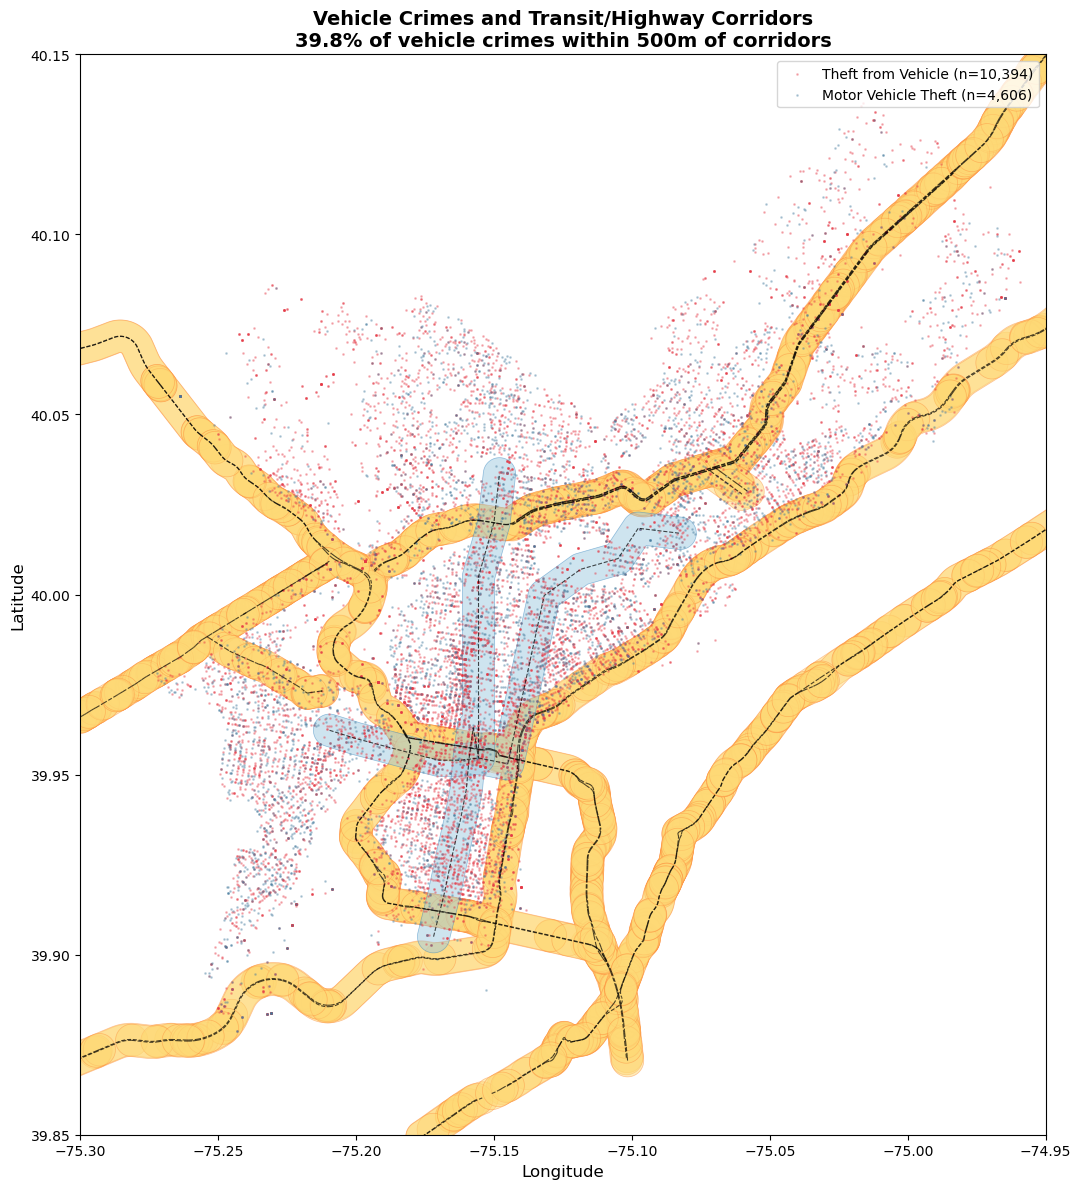

In [14]:
fig, ax = plt.subplots(figsize=(14, 12))

# Plot corridor buffers by type
corridors_buffered[corridors_buffered['type'] == 'highway'].plot(
    ax=ax, color='#FED976', alpha=0.5, edgecolor='#FD8D3C', linewidth=0.5,
    label='Highway Buffer (500m)'
)

if transit_mask.any():
    corridors_buffered[corridors_buffered['type'] == 'subway'].plot(
        ax=ax, color='#9ECAE1', alpha=0.5, edgecolor='#3182BD', linewidth=0.5,
        label='Transit Buffer (500m)'
    )

# Sample crimes for visualization (too many to plot all)
sample_size = min(15000, len(gdf_vehicle))
sample = gdf_vehicle.sample(sample_size, random_state=42)

# Plot crimes by category
tfv = sample[sample['text_general_code'] == 'Theft from Vehicle']
mvt = sample[sample['text_general_code'] == 'Motor Vehicle Theft']

ax.scatter(tfv.geometry.x, tfv.geometry.y, c='#E63946', s=1, alpha=0.3, 
           label=f'Theft from Vehicle (n={len(tfv):,})')
ax.scatter(mvt.geometry.x, mvt.geometry.y, c='#457B9D', s=1, alpha=0.3, 
           label=f'Motor Vehicle Theft (n={len(mvt):,})')

# Add corridor centerlines for reference
corridors.plot(ax=ax, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

# Set bounds
ax.set_xlim(bounds['min_lon'], bounds['max_lon'])
ax.set_ylim(bounds['min_lat'], bounds['max_lat'])

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Vehicle Crimes and Transit/Highway Corridors\n'
             f'{pct_any:.1f}% of vehicle crimes within {buffer_meters}m of corridors', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# Save figure
output_path = REPORTS_DIR / 'vehicle_crimes_corridor_map.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
artifacts.append(('vehicle_crimes_corridor_map.png', 'Static map with corridor overlay'))
print(f"Saved: {output_path}")

plt.show()

## 5. Temporal Analysis

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/vehicle_crimes_hourly_corridor.png


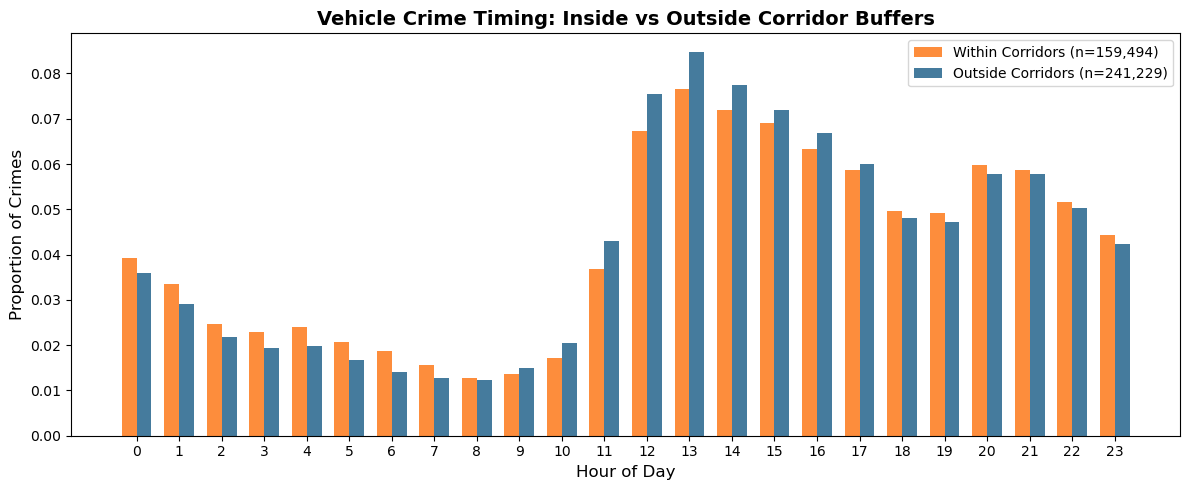

In [15]:
# Extract hour from dispatch time
gdf_vehicle['hour'] = pd.to_datetime(gdf_vehicle['dispatch_date_time'], errors='coerce').dt.hour

# Compare crime patterns inside vs outside corridor buffers
inside = gdf_vehicle[gdf_vehicle['in_any_corridor']]
outside = gdf_vehicle[~gdf_vehicle['in_any_corridor']]

inside_hourly = inside.groupby('hour').size() / len(inside)
outside_hourly = outside.groupby('hour').size() / len(outside)

fig, ax = plt.subplots(figsize=(12, 5))
hours = range(24)
width = 0.35

ax.bar([h - width/2 for h in hours], inside_hourly.reindex(hours, fill_value=0), 
       width, label=f'Within Corridors (n={len(inside):,})', color='#FD8D3C')
ax.bar([h + width/2 for h in hours], outside_hourly.reindex(hours, fill_value=0),
       width, label=f'Outside Corridors (n={len(outside):,})', color='#457B9D')

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Proportion of Crimes', fontsize=12)
ax.set_title('Vehicle Crime Timing: Inside vs Outside Corridor Buffers', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(hours)

plt.tight_layout()

# Save figure
output_path = REPORTS_DIR / 'vehicle_crimes_hourly_corridor.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
artifacts.append(('vehicle_crimes_hourly_corridor.png', 'Hourly patterns by corridor proximity'))
print(f"Saved: {output_path}")

plt.show()

## 6. Year-over-Year Trends

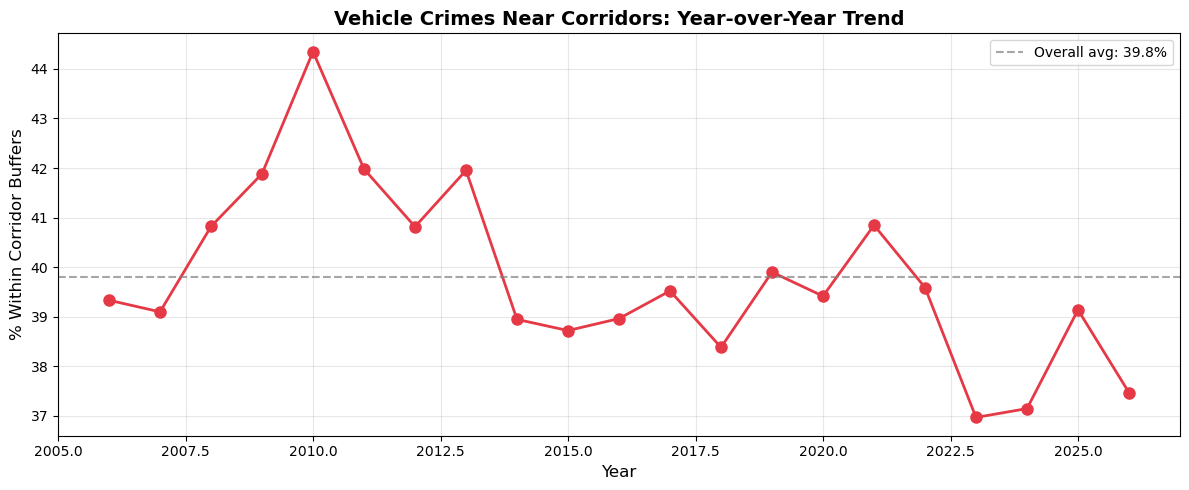


Yearly Statistics:
 year  total  in_corridor  pct_in_corridor
 2006  25615        10075        39.332422
 2007  23784         9299        39.097713
 2008  20470         8356        40.820713
 2009  17823         7465        41.884082
 2010  23191        10285        44.349101
 2011  22723         9539        41.979492
 2012  16817         6864        40.815841
 2013  15453         6483        41.953019
 2014  15342         5975        38.945379
 2015  14429         5587        38.720632
 2016  15302         5962        38.962227
 2017  14653         5791        39.520917
 2018  15148         5814        38.381304
 2019  14980         5977        39.899866
 2020  15357         6053        39.415250
 2021  19955         8151        40.846906
 2022  27084        10722        39.587949
 2023  33627        12431        36.967318
 2024  24183         8983        37.145929
 2025  23626         9247        39.139084
 2026   1161          435        37.467700


In [16]:
# Extract year
gdf_vehicle['year'] = pd.to_datetime(gdf_vehicle['dispatch_date'], errors='coerce').dt.year

# Calculate yearly corridor percentages
yearly_stats = []
for year in sorted(gdf_vehicle['year'].dropna().unique()):
    year_data = gdf_vehicle[gdf_vehicle['year'] == year]
    total = len(year_data)
    in_corridor = year_data['in_any_corridor'].sum()
    pct = in_corridor / total * 100 if total > 0 else 0
    yearly_stats.append({
        'year': int(year),
        'total': total,
        'in_corridor': in_corridor,
        'pct_in_corridor': pct
    })

yearly_df = pd.DataFrame(yearly_stats)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(yearly_df['year'], yearly_df['pct_in_corridor'], marker='o', linewidth=2, 
        color='#E63946', markersize=8)
ax.axhline(pct_any, linestyle='--', color='gray', alpha=0.7, label=f'Overall avg: {pct_any:.1f}%')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('% Within Corridor Buffers', fontsize=12)
ax.set_title('Vehicle Crimes Near Corridors: Year-over-Year Trend', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nYearly Statistics:")
print(yearly_df.to_string(index=False))

## 7. Export Results

In [17]:
# Save corridor statistics
corridor_summary = pd.DataFrame({
    'corridor_type': ['highway', 'transit', 'any'],
    'pct_of_crimes': [pct_highway, pct_transit, pct_any],
    'crime_count': [
        gdf_vehicle['in_highway_buffer'].sum(),
        gdf_vehicle['in_transit_buffer'].sum(),
        gdf_vehicle['in_any_corridor'].sum()
    ],
    'buffer_meters': buffer_meters,
    'total_vehicle_crimes': total_crimes
})

stats_path = REPORTS_DIR / 'vehicle_crimes_corridor_stats.csv'
corridor_summary.to_csv(stats_path, index=False)
artifacts.append(('vehicle_crimes_corridor_stats.csv', 'Corridor statistics'))
print(f"Saved: {stats_path}")

# Save per-corridor breakdown
per_corridor_path = REPORTS_DIR / 'vehicle_crimes_per_corridor.csv'
per_corridor.to_csv(per_corridor_path, index=False)
artifacts.append(('vehicle_crimes_per_corridor.csv', 'Per-corridor breakdown'))
print(f"Saved: {per_corridor_path}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/vehicle_crimes_corridor_stats.csv
Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/vehicle_crimes_per_corridor.csv


In [18]:
# Calculate additional statistics for report
tfv_total = len(gdf_vehicle[gdf_vehicle['text_general_code'] == 'Theft from Vehicle'])
tfv_in_corridor = gdf_vehicle[(gdf_vehicle['text_general_code'] == 'Theft from Vehicle') & 
                               gdf_vehicle['in_any_corridor']].shape[0]
mvt_total = len(gdf_vehicle[gdf_vehicle['text_general_code'] == 'Motor Vehicle Theft'])
mvt_in_corridor = gdf_vehicle[(gdf_vehicle['text_general_code'] == 'Motor Vehicle Theft') & 
                               gdf_vehicle['in_any_corridor']].shape[0]

# Generate report content
report_content = f"""# Vehicle Crimes Corridor Analysis Report

## Executive Summary

**{pct_any:.1f}%** of vehicle crimes in Philadelphia occur within {buffer_meters}m (~{buffer_meters//100} blocks) of major transit/highway corridors.

## Key Findings

### Corridor Proximity

| Corridor Type | Crimes | % of Total |
|---------------|--------|------------|
| Highway corridors | {gdf_vehicle['in_highway_buffer'].sum():,} | {pct_highway:.1f}% |
| Transit corridors | {gdf_vehicle['in_transit_buffer'].sum():,} | {pct_transit:.1f}% |
| Any corridor | {gdf_vehicle['in_any_corridor'].sum():,} | {pct_any:.1f}% |

### Per-Corridor Breakdown (Top 10)

| Corridor | Type | Incidents | % of Total |
|----------|------|-----------|------------|
"""

for _, row in per_corridor.head(10).iterrows():
    report_content += f"| {row['corridor']} | {row['type']} | {int(row['incident_count']):,} | {row['pct_of_total']:.1f}% |\n"

report_content += f"""
### Crime Type Distribution

| Crime Type | Total | Within Corridors | % Within |
|------------|-------|------------------|----------|
| Theft from Vehicle | {tfv_total:,} | {tfv_in_corridor:,} | {tfv_in_corridor/tfv_total*100:.1f}% |
| Motor Vehicle Theft | {mvt_total:,} | {mvt_in_corridor:,} | {mvt_in_corridor/mvt_total*100:.1f}% |

## Methodology

- **Buffer distance**: {buffer_meters}m from corridor centerlines
- **Corridors analyzed**: {', '.join(sorted(per_corridor['corridor'].head(6).tolist()))}
- **Crime types**: Theft from Vehicle, Motor Vehicle Theft
- **Total vehicle crimes**: {total_crimes:,}
- **Analysis period**: All available years

## Implications

1. Vehicle crimes show {'strong' if pct_any > 30 else 'moderate'} concentration near major corridors
2. {'Highway' if pct_highway > pct_transit else 'Transit'} corridors have higher incidence rates
3. Consider enhanced patrols at corridor access points and park-and-ride facilities
4. Potential for targeted awareness campaigns at highway rest areas and transit stations

## Artifacts Generated

- `vehicle_crimes_corridor_map.png` - Static map with corridor overlay
- `vehicle_crimes_hourly_corridor.png` - Hourly pattern comparison
- `vehicle_crimes_corridor_stats.csv` - Summary statistics
- `vehicle_crimes_per_corridor.csv` - Per-corridor breakdown

---
*Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}*
*Notebook: vehicle_crimes_corridors.ipynb*
"""

report_path = REPORTS_DIR / 'vehicle_corridor_analysis.md'
with open(report_path, 'w') as f:
    f.write(report_content)

artifacts.append(('vehicle_corridor_analysis.md', 'Analysis summary report'))
print(f"Saved: {report_path}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/vehicle_corridor_analysis.md


## 8. Summary

In [19]:
runtime = time.time() - RUNTIME_START

print("\n" + "="*60)
print("NOTEBOOK COMPLETE: Vehicle Crimes Corridor Analysis (POLICY-02)")
print("="*60)

print(f"\n📊 KEY FINDING:")
print(f"   {pct_any:.1f}% of vehicle crimes occur within {buffer_meters}m of corridors")

print(f"\n📁 Artifacts generated:")
for name, desc in artifacts:
    print(f"   - reports/{name}: {desc}")

print(f"\n⏱️  Runtime: {runtime:.1f} seconds")
print(f"\n✅ All outputs saved to: {REPORTS_DIR}")


NOTEBOOK COMPLETE: Vehicle Crimes Corridor Analysis (POLICY-02)

📊 KEY FINDING:
   39.8% of vehicle crimes occur within 500m of corridors

📁 Artifacts generated:
   - reports/vehicle_crimes_corridor_map.png: Static map with corridor overlay
   - reports/vehicle_crimes_hourly_corridor.png: Hourly patterns by corridor proximity
   - reports/vehicle_crimes_corridor_stats.csv: Corridor statistics
   - reports/vehicle_crimes_per_corridor.csv: Per-corridor breakdown
   - reports/vehicle_corridor_analysis.md: Analysis summary report

⏱️  Runtime: 28.0 seconds

✅ All outputs saved to: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports
